In [1]:
import pickle
import pandas as pd
from pathlib import Path
import structlog
import matplotlib.pyplot as plt
from ml_assemblr.main_components.data_pod import DataPod
from ml_assemblr.main_components.data_pod_list import DataPodList
from home_credit_helper.config import cfg, cfg_small_dataset
from home_credit_helper.constant import *
from ml_assemblr.utils.logging.setup_logging import setup_logging
import warnings

warnings.filterwarnings("ignore", category=Warning)

In [2]:
setup_logging(is_pretty_render=True)
# cfg = cfg_small_dataset
del cfg_small_dataset

In [3]:
from ml_assemblr.transfromer.column_type.features_setter import TopDownFeaturesSetter
from ml_assemblr.transfromer.model.xgb_model import XGBModel, get_xgb_config

In [4]:
from home_credit_helper.evaluation.main import evaluation

In [5]:
import xgboost as xgb
import optuna

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
with open(cfg.research_cache_path / "03_dp.pkl", "rb") as f:
    dp: DataPod = pickle.load(f)

# Recursive Feature Elimination Method

In [8]:
feature_setters = TopDownFeaturesSetter()
dp = dp.fit_transform(feature_setters)

In [9]:
from ml_assemblr.transfromer.cross_validator.cross_validator import CrossValidator
from sklearn.model_selection import ShuffleSplit

## Train with full features

In [10]:
cross_validator = CrossValidator(sklearn_cv=ShuffleSplit(n_splits=3, test_size=0.2, random_state=42))
dp = dp.fit_transform(cross_validator)

In [11]:
optuna_study_path = f"sqlite:///{cfg.research_cache_path / "optuna_studies.db"}"

study = optuna.load_study(
    study_name="xgb-hyperparam-tuning-full-features", storage=optuna_study_path
)
xgb_config = get_xgb_config(study)

dp_untrain = dp.copy()
cv_count = len(dp.variables["cv_idx_map"]['cv_split_idx_in_column_type'])

for i in range(cv_count):
    xgb_model = XGBModel(**xgb_config, fit_on_split="train", cv_idx=i)
    dp: DataPod = dp.fit_transform(xgb_model)
dp = evaluation(dp, "auroc_valid")

In [12]:
dp.variables["evaluation"]['df_evaluation']

,metric,value_cv_0,value_cv_1,value_cv_2,value_mean,value_std
0,auroc_train,0.813549,0.814954,0.815230,0.814578,0.000736
1,auroc_valid,0.771960,0.768394,0.772363,0.770906,0.001784
2,auroc_test,0.769847,0.769216,0.772387,0.770483,0.001371


In [13]:
auroc_full = dp.variables["evaluation"]["objective_auroc_valid"]
auroc_full

0.7709055277108945

## Estimate features importance and recursive elimination

In [14]:
df_shap_importance: pd.DataFrame = dp.variables["evaluation"]["agg_shap_results"]['df_shap_importance_valid']
df_shap_importance = df_shap_importance.sort_values("value_mean", ascending=True)

# top 5 important features
df_shap_importance.tail(5)

,feature,value_cv_0,value_cv_1,value_cv_2,value_mean,value_std
106,DAYS_EMPLOYED_PERC,2.442636,2.513462,2.980253,2.645451,0.238500
6,AMT_GOODS_PRICE,2.888752,3.225366,2.144814,2.752977,0.451460
29,EXT_SOURCE_1,3.314415,3.437728,3.161301,3.304482,0.113069
31,EXT_SOURCE_3,6.730995,7.027716,6.996282,6.918331,0.133087
30,EXT_SOURCE_2,7.579769,7.352978,7.559937,7.497561,0.102556


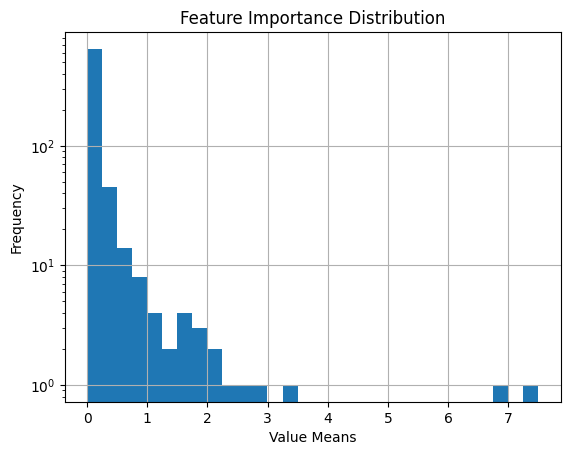

In [15]:
# feature importance distribution

df_shap_importance['value_mean'].hist(bins=30)
plt.yscale('log')
plt.xlabel('Value Means')
plt.ylabel('Frequency')
plt.title('Feature Importance Distribution')
plt.show()

In [16]:
# config feature elimination process
total_original_features_count = df_shap_importance.shape[0]

feature_names = list(df_shap_importance[df_shap_importance["value_mean"] != 0]["feature"])
low_important_feature_count = total_original_features_count - len(feature_names)
current_feature_names = feature_names[:]

feature_names = ["first_loop"] + feature_names + ["last_loop"]

metric_tolerance = 0.0005

In [17]:
feature_selection_states = {
  "dp_untrain": dp_untrain,
  "feature_names": feature_names,
  "current_feature_names": current_feature_names,
  "low_important_feature_count": low_important_feature_count,
  "metric_tolerance": metric_tolerance,
  "total_original_features_count": total_original_features_count,
  "xgb_config": xgb_config,
  "auroc_full": auroc_full,
}

In [18]:
with open(cfg.research_cache_path / "05_feature_selection_states.pkl", "wb") as f:
    pickle.dump(feature_selection_states, f)

In [19]:
raise

RuntimeError: No active exception to reraise